In [4]:
import minio
import os
import cv2 as cv
import matplotlib.pyplot as plt
import torch
import intel_extension_for_pytorch as ipex
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

minio_client = minio.Minio(
    os.environ['MINIO_ENDPOINT'],
    access_key=os.environ['MINIO_ACCESS_KEY'],
    secret_key=os.environ['MINIO_SECRET_KEY'],
    secure=False
)

In [2]:
class MultiCam:
    def __init__(self, video_list):
        self.video_list = video_list
        self.cap_list: list[cv.VideoCapture] = []
        for video in video_list:
            self.cap_list.append(cv.VideoCapture(video))
        self.frame_count = [int(cap.get(cv.CAP_PROP_FRAME_COUNT)) for cap in self.cap_list]

    def seek(self, frame, sync=True):
        max_frame = max(self.frame_count)
        if frame > max_frame:
            print('Frame number exceeds the max frame count')
            return

        if sync:
            for idx, cap in enumerate(self.cap_list):
                frame_diff = max_frame - self.frame_count[idx]
                if frame_diff > 0:
                    frame_diff -= 1
                cap.set(cv.CAP_PROP_POS_FRAMES, frame - frame_diff)

        else:            
            for cap in self.cap_list:                
                if frame > self.frame_count[self.cap_list.index(cap)]:
                    print('Frame number exceeds the total frame count')
                    return
                cap.set(cv.CAP_PROP_POS_FRAMES, frame)

    def get_frame(self, frame):
        self.seek(frame)
        frame_list = []
        for cap in self.cap_list:
            ret, frame = cap.read()
            frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
            frame_list.append(frame)
        return frame_list

    def release(self):
        for cap in self.cap_list:
            cap.release()

resolution = (1920 *0.5, 1080 *0.5)

def plot_frame(frame_list, height=10, landscape=False):
    # Plot 3 images side by side without axis and any gap between them
    if landscape:
        fig, ax = plt.subplots(1, len(frame_list),figsize=(height*resolution[0]/resolution[1]*3.1, height))
    else:
        fig, ax = plt.subplots(len(frame_list), 1, figsize=(height*resolution[0]/resolution[1], height*3))
    for idx, frame in enumerate(frame_list):
        ax[idx].imshow(frame)
        ax[idx].axis('off')
        ax[idx].set_aspect('auto')
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
    fig.tight_layout()
    plt.show()

In [3]:
bucket = 'highjump'
path = 'raw_data/2025/03/18/run13/'
download_path = 'data/videos/'

video_list = list(minio_client.list_objects(bucket, path))

for video in video_list:
    minio_client.fget_object(bucket, video.object_name, download_path + video.object_name.split('/')[-1])

In [7]:
checkpoint = "../../data/models/sam2/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint,device='xpu'))


2025-03-19 22:57:13,936 - root - INFO - Loaded checkpoint sucessfully


In [8]:
multi_cam = MultiCam([download_path + 'sidecam.mp4', download_path + 'curvecam.mp4', download_path + 'curvecam2.mp4'])

print(multi_cam.frame_count)
frame_list_1 = multi_cam.get_frame(3865)

[6152, 6149, 6155]


In [10]:
cv.imwrite('frame1.jpg', cv.cvtColor(frame_list_1[0], cv.COLOR_BGR2RGB))
cv.imwrite('frame2.jpg', cv.cvtColor(frame_list_1[1], cv.COLOR_BGR2RGB))
cv.imwrite('frame3.jpg', cv.cvtColor(frame_list_1[2], cv.COLOR_BGR2RGB))

True

In [10]:
import numpy as np
predictor.set_image(frame_list_1[0])
input_point = np.array([[500, 375]])
input_label = np.array([1])

2025-03-19 22:58:41,851 - root - INFO - For numpy array image, we assume (HxWxC) format
2025-03-19 22:58:41,890 - root - INFO - Computing image embeddings for the provided image...
2025-03-19 22:58:41,906 - root - INFO - Image embeddings computed.


In [11]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

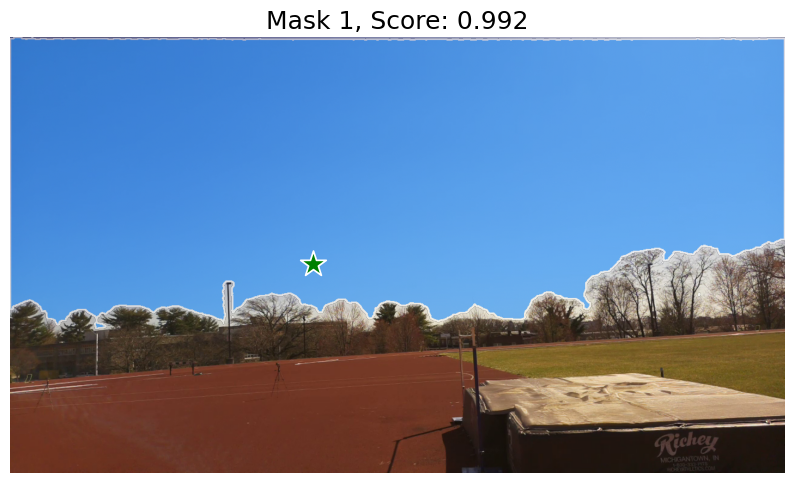

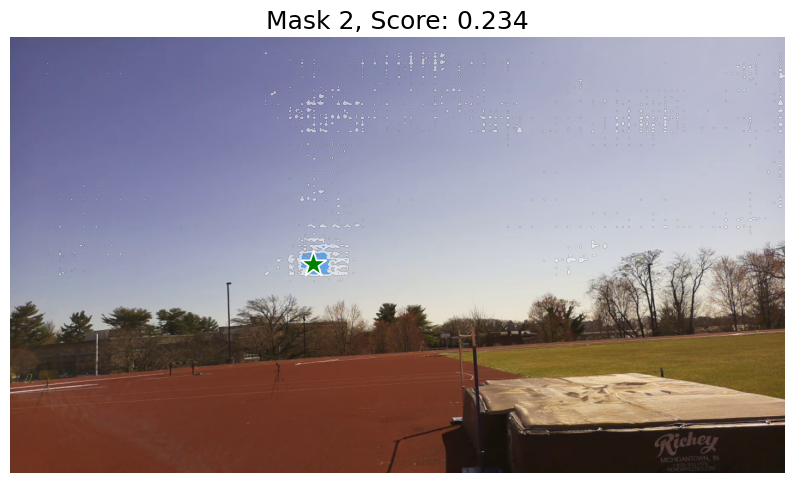

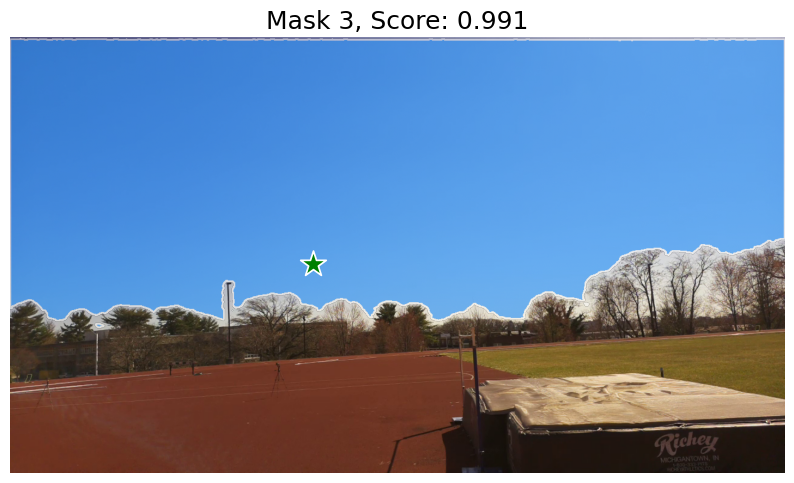

In [14]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()
show_masks(frame_list_1[0], masks, scores, point_coords=input_point, input_labels=input_label, borders=True)
